In [99]:
import torch
from torch_geometric.data import DataLoader
import pandas as pd

In [100]:
from interpret_utils import (
    visualize_attribution, 
    load_trained_model, 
    get_node_attribution_gnn, 
    summarize_attributions, 
    plot_top_atoms_histogram, 
    plot_prediction_vs_target, 
    plot_mean_attribution_by_element
)

from data.data_loaders import preproccess_data, df_to_graph_list

In [101]:
data_file = './data/curated-solubility-dataset.csv'  # <-- Change this to the path of your CSV file
df = preproccess_data(data_file)

[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:51] WARNING: not removing hydrogen atom without neighbors
[04:58:52] WARNING: not removing hydrogen atom without neighbors
[04:58:52] WARNING: not removing hydrogen atom without neighbors
[04:58:52] WARNING: not removing hydrogen atom without neighbors
[04:58:52] WARNING: not removing hydrogen atom without neighbors
[04:58:52] WARNING: not r

In [102]:
graph_list = df_to_graph_list(df)

In [103]:
# patch SMILES to each graph needed for visualization
for i, data in enumerate(graph_list):
    data.smiles = df.iloc[i]['SMILES']

In [104]:
data_loader = DataLoader(graph_list, batch_size=1, shuffle=False)

/Users/tanishsharma/miniforge3/envs/pyg_env/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [105]:
def fix_smiles(batch):
    if hasattr(batch, "smiles") and isinstance(batch.smiles, list):
        batch.smiles = batch.smiles[0]  # Unwrap the single element
    return batch

In [106]:
fixed_data_loader = [fix_smiles(batch) for batch in list(data_loader)]

In [107]:
model_args = {
    'num_node_features': 6,
    'edge_attr_dim': 4,
    'u_dim': 6,
    'hidden_dim': 64,
    'output_dim': 1,
}

In [108]:
model = load_trained_model('best_model.pth', model_args=model_args, device='cpu')

/Users/tanishsharma/Documents/uoft/2nd_sem_3rd_yr/ece324/BioSolveAI/interpret_utils.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(mod

In [109]:
#############################################
# interpretability on a single sample
#############################################

node_scores, sample_data, prediction, true_target = get_node_attribution_gnn(model, fixed_data_loader, sample_index=0, device='cpu')
print(f"Prediction: {prediction:.4f}, True Value: {true_target:.4f}")

Prediction: -0.4588, True Value: -0.4070



==== Node Attribution Heatmap - Sample Molecule ====



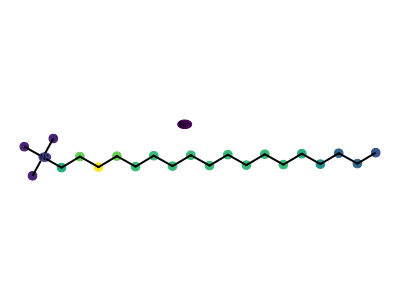

In [110]:
visualize_attribution(sample_data.smiles, node_scores, molecule_name="Sample Molecule", cmap_name='viridis')

In [121]:
#############################################
# interpretability analysis across samples
#############################################

# summary of 10 samples
summary = summarize_attributions(model, fixed_data_loader, num_samples=30, device='cpu')

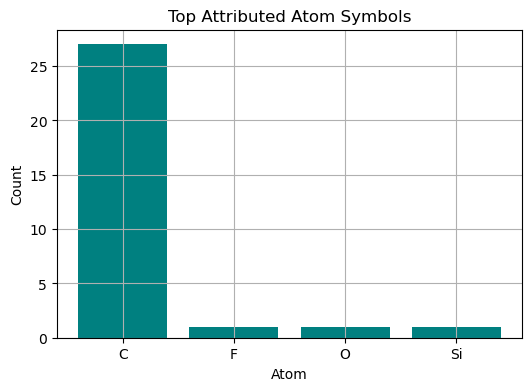

In [122]:
# Plot a histogram of the top attributed atom symbols
plot_top_atoms_histogram(summary)

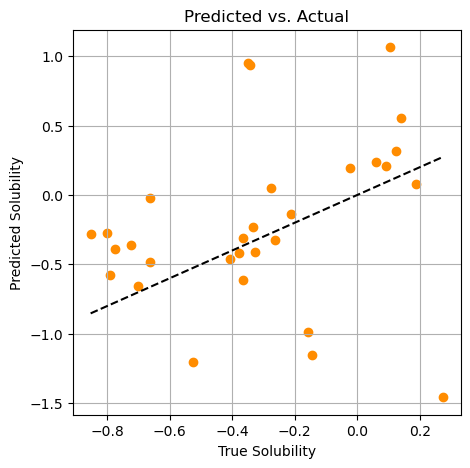

In [123]:
# Plot predicted versus actual solubility values for the samples
plot_prediction_vs_target(summary)

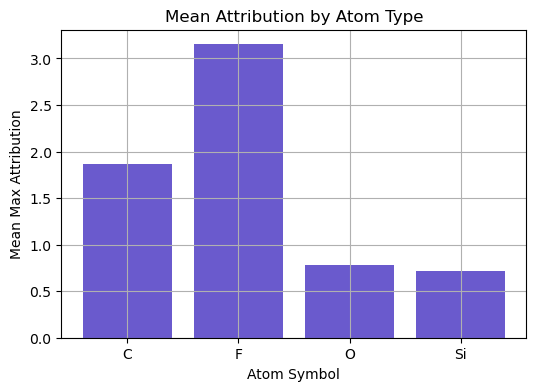

In [124]:
# Plot mean attribution scores grouped by atom type
plot_mean_attribution_by_element(summary)

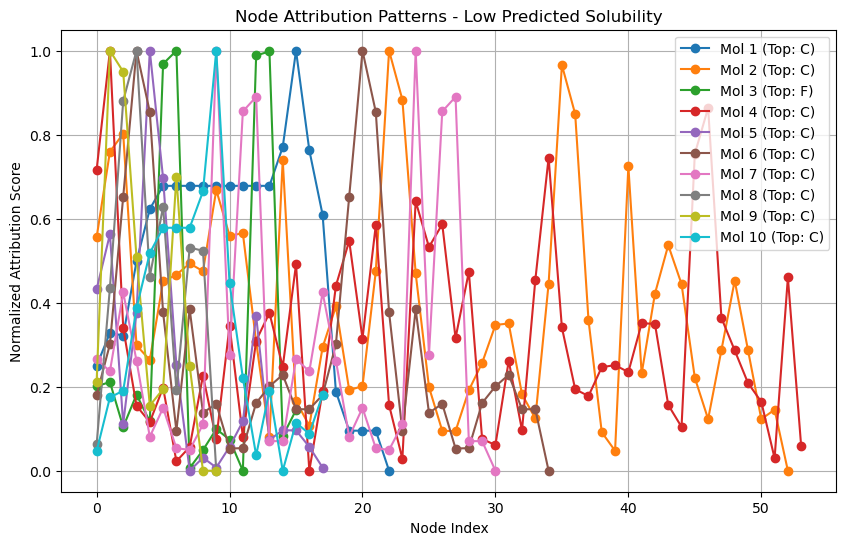

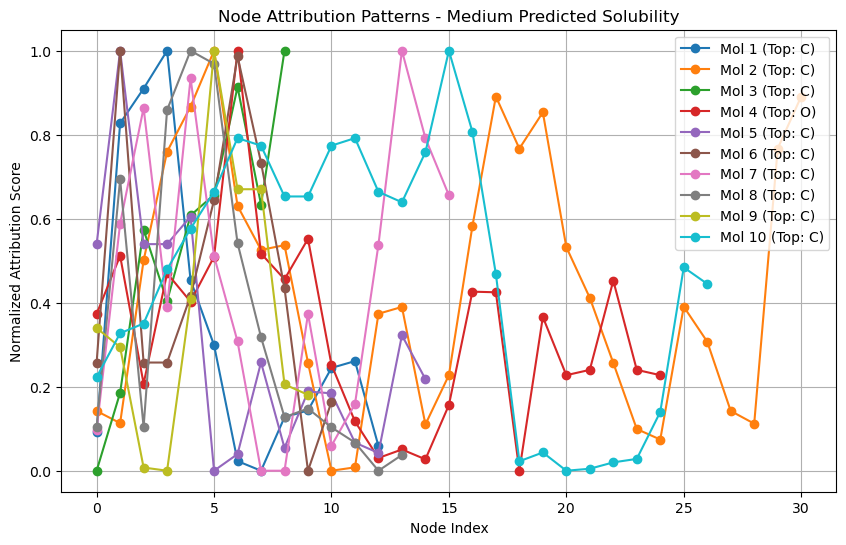

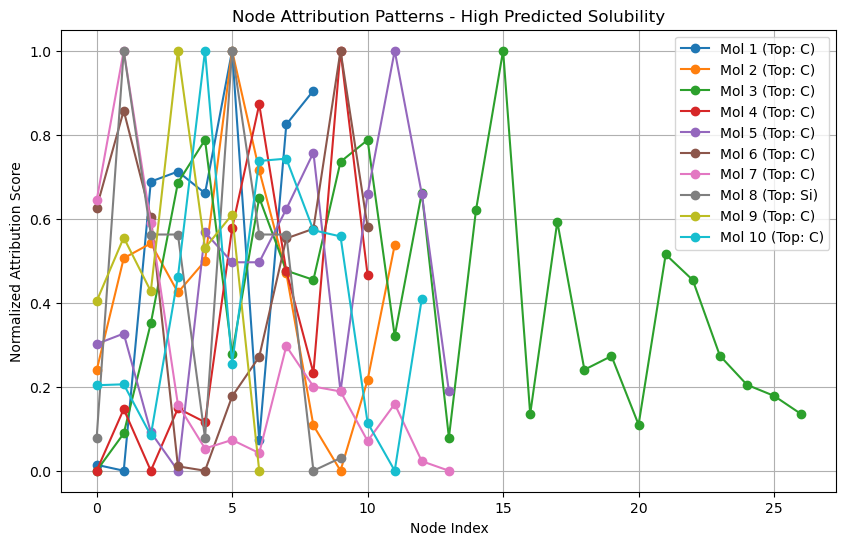

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Node-level Explanation Comparison ---
# three bins: low, medium, high

#tuple: (pred, target, top_atom, scores))
preds = np.array([s[0] for s in summary])

# Define bins using percentiles
low_thresh = np.percentile(preds, 33) # 33 & 66 are thresholds
high_thresh = np.percentile(preds, 66)

# Group the summary entries into bins
low_group = [s for s in summary if s[0] <= low_thresh]
med_group = [s for s in summary if low_thresh < s[0] <= high_thresh]
high_group = [s for s in summary if s[0] > high_thresh]

# plot normalized node attributions for each molecule in a group
def plot_group_attributions(group, group_name):
    plt.figure(figsize=(10, 6))
    for idx, (pred, target, top_atom, scores) in enumerate(group):
        # Normalize scores to [0, 1] 
        if scores.max() > scores.min():
            scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            scores_norm = scores
        plt.plot(scores_norm, marker='o', linestyle='-', label=f'Mol {idx+1} (Top: {top_atom})')
    plt.title(f'Node Attribution Patterns - {group_name} Predicted Solubility')
    plt.xlabel('Node Index')
    plt.ylabel('Normalized Attribution Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot 
plot_group_attributions(low_group, 'Low')
plot_group_attributions(med_group, 'Medium')
plot_group_attributions(high_group, 'High')
